<h1 align='center'> Stainless Steel Welding Type Classification </h3>

<p> The General idea of this notebook is to highlight all the process and subprocesses done for Stainless Steel Welding Type Classification.<br>For this project we have used the dataset provided <a href="https://www.kaggle.com/code/kerneler/starter-tig-stainless-steel-304-ee6df282-0/data">Here</a>. </p>

<h4> <u> Dataset Discussion </u> </h4>
<div>
    <img src='Assets/Dataset_Labels.png' align='right' width=600 height=300>
    <p align='left'><br>Our Dataset has been label encoded as following: <br> The idea is that provided an image our classifier will be able to classify the results as one of the following labels. <br><br>["good weld","burn through","contamination","lack of fusion","lack of shielding gas","high travel speed"]<br><br>
    Since we are following supervised approach we have a json file which maps each image with corresponding output labels which can be used to map each image with corresponding labels. <br><br> The mentioned json file can be seen below: <br> <br></p>
    <img src='Assets/json_files.png' width=550>
</div>

<br>
<h2> 0. Intalling Dependencies </h2>

In [ ]:
!pip install -r requirements

<h2> 1. Importing Dependencies </h2>

Let's import all the dependencies so we can use it later

In [17]:
import json
import numpy as np 
from PIL import Image
import tensorflow as tf
import os
from sklearn.metrics import classification_report
import json
import matplotlib.pyplot as plt
import sys
from keras import backend as K

np.set_printoptions(threshold=sys.maxsize)

<h2> 1. PreProcessing </h2>

<p> Once Downloaded please unzip the dataset on the same working directory and the folder directory should be: <br>

<i>../ss304/train/train.json</i>
</p>

<br>

<p> The steps invovled in the preprocessing steps are: <br>
    <ol>
        <li> Getting path of json as input train.json for train dataset and test.json for test dataset </li>
        <li> Getting images path from jsons </li>
        <li> Opening image and resizing them to 200x200 dimensions </li>
        <li> Converting the resized image to numpy array </li>
        <li> Combing all individual images array to one huge array X for training and X test for testing </li>
        <li> Getting all the labels from jsons and converting into one huge array Y for training and Y test for testing </li>
    </ol>
    <br> These steps can be visualized from the image below: 
    <img src='Assets/preprocessing_under_hood.png'>
    <br>
    Note: This cell will take a bit of time to run because its doing alot of computations at once.
</p>



In [2]:
def convert_to_array(i,features,f):

    if f==0:
        image=features[i]
        
    else: 
        image=i
    
    image = Image.open(image)
    if f==1:
        plt.imshow(image,cmap='gray')
    image=image.resize((200,200))
    numpydata = np.asarray(image)
    numpydata = numpydata.astype('float32')

    # Normalize to the range 0-1
    numpydata /= 255.0
    return numpydata


def get_images_array_and_labels(path):
    print('Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed')
    with open(path,'r') as datasets:
        datasets=json.load(datasets)
    features=list(datasets.keys())
    features=['/'.join(path.split('\\')[0:-1])+'/'+str(i) for i in features]
    features=np.array([convert_to_array(i,features,0) for i in range(len(features))])
    labels=np.array(list(datasets.values())).reshape(-1,1)
    return features,labels
    
    

X1,Y1=get_images_array_and_labels('ss304\\train\\train.json')
X2,Y2=get_images_array_and_labels('ss304\\valid\\valid.json')
Xtest,Ytest=get_images_array_and_labels('ss304\\test\\test.json')
X=np.concatenate((X1,X2),axis=0)
Y=np.concatenate((Y1,Y2),axis=0)

Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed
Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed
Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed


<h2> 2. Building our Convolutional Nerual Network </h2>

<p> The overall architecture of the entire CNN designed is provided below </p>

<img src='Assets/CNN Architecture.png'>

The image above can be interpreted as: 
<ul>
    <li> Feed input array to the CNN </li>
    <li> The first convlution layer has 32 filters with it </li>
    <li> The output of first convlution is reduced with maxpooling </li>
    <li>Second convlution layer is carried out with 64 filters with it </li>
    <li> The output of second convlution layer is again reduced with maxpooling </li>
    <li>Flatten the final output from convlution portion </li>
    <li> The Flattened one d array is connected to a fully connected layer with 64 neurons on first layer and 6 outputs on final layer </li>
</ul>

This cell also has some utilities functions with the model creation portions 


In [6]:
def write_training_history(history):
    with open('training_checkpoints.json','w') as f:
            json.dump(history,f)

def load_training_history():
    with open('training_checkpoints.json','r') as f:
            f=json.load(f)
    return f


def get_updated_history(history):
    
    if 'training_checkpoints.json' not in os.listdir(os.getcwd()):
        write_training_history(history)
    else: 
        f=load_training_history()
        f['loss']=f['loss']+history['loss']
        f['accuracy']=f['accuracy']+history['accuracy']
        f['val_loss']=f['val_loss']+history['val_loss']
        f['val_accuracy']=f['val_accuracy']+history['val_accuracy']
        write_training_history(f)
    
    return load_training_history()

def load_previous_model(CNN_model):
    if 'Stainless_Steel_Classification_model.h5' in os.listdir(os.getcwd()):
        CNN_model=tf.keras.models.load_model('Stainless_Steel_Classification_model.h5')
    else: 
         if 'training_checkpoints.json' in os.listdir(os.getcwd()):
             os.remove('training_checkpoints.json') 
    
    return CNN_model

def plot_metrics_for_training(history):
    
    plt.figure(figsize=(25, 10))
    plt.subplot(221)
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label = 'val_accuracy')
    plt.xticks(np.arange(len(history['accuracy'])), np.arange(1, len(history['accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(222)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.xticks(np.arange(len(history['loss'])), np.arange(1, len(history['loss'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([0.001, 4.5])
    plt.legend(loc='upper center')
    plt.savefig('output_details.png')

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_cnn_model():
    model=tf.keras.models.Sequential()

    #Convlution Process Starts here.
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(200, 200, 1)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    #Fully Connected Layer from here 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.0005)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(16,activation='relu'))
    
    model.add(tf.keras.layers.Dense(6,activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(l2=0.0005))) 
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    #opt=tf.keras.optimizers.RMSprop(learning_rate=0.0005)

    #Compile the CNN Model
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    return model
    

CNN_model=create_cnn_model()
callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',restore_best_weights=True )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

<h2> 3. Training CNN Model </h2> 
<p> The steps invovled for training the blank model created earlier is shown  below: </p>
<img src='Assets/training Architecture.png'>
From the Image above we can interpret that: 
<ul>
    <li> Initially we get the blank model built from previous cell </li><br>
    <li> Then we check the working directory for model file if present or not </li><br>
    <li> If model file is present then: 
        <ul>
            <li>    We load its weights to blank model and history  </li>
        </ul>
    </li><br>
    <li> We train the blank model (loaded with weights or random weights depends on previous step) </li><br>
    <li> Once training completed we save the history (combined with previous history or not) and current model on working directory </li>

In [11]:
CNN_model=load_previous_model(CNN_model)
history_for_plotting=CNN_model.fit(X,Y,epochs=10,batch_size=64,validation_data=(Xtest,Ytest),shuffle=True,callbacks=[callback])
history_for_plotting=get_updated_history(history_for_plotting.history)
CNN_model.save('Stainless_Steel_Classification_model.h5')


Epoch 1/10
530/530 [==============================] - 630s 1s/step - loss: 0.2526 - accuracy: 0.9405 - val_loss: 0.2332 - val_accuracy: 0.9578
Epoch 2/10
 80/530 [===>..........................] - ETA: 14:29 - loss: 0.2011 - accuracy: 0.9506

KeyboardInterrupt: 

<h2> 4. Visualizing the performance of the model </h2>
<p> For Visualization of the project we have followed the process as: </p>
<img src='Assets/Visualizing Results.png' align='left'><p align='right'> From the figure we can understand that we first load the history file which is present in json format<br><br> That same file has details in complicated format we convert it into a format that can be understood by us and is displayed on the screen <br><br>  Finally the interpretable output is plotted in the form of graph to visually see how the model works on data </p>

Total Number of Epochs Trained: 10
--------------------
Average Training Loss: 0.5137725964188575
Last Training Loss: 0.1613917052745819
--------------------
Average Validation  Loss: 0.40572118759155273
Last Validation  Loss: 0.18857191503047943
--------------------
Average Training Accuracy: 0.8492852509021759
Last Training Accuracy: 0.969219982624054
--------------------
Average Validation Accuracy: 0.9007975041866303
Last Validation Accuracy: 0.9568100571632385
--------------------


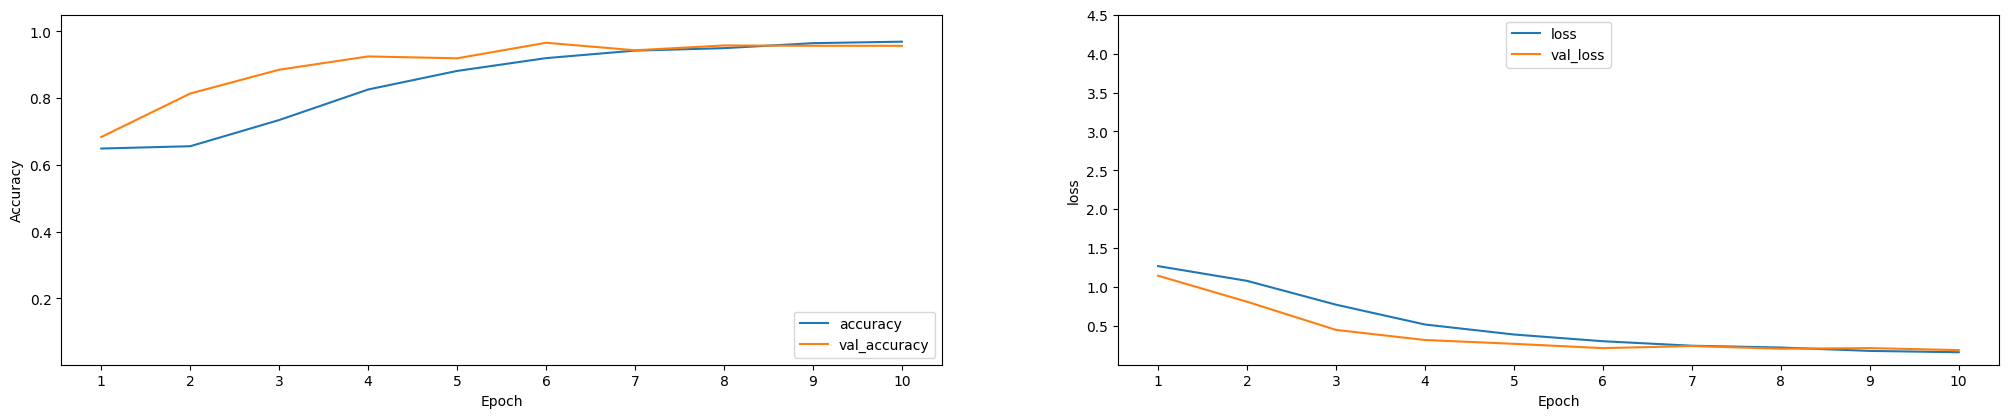

In [67]:
def get_results_details(history):
    
    epochs=len(history['loss'])
    print(f'Total Number of Epochs Trained: {epochs}')
    print('--'*10)
    
    #Loss Details 
    loss= (sum(history['loss']))/(epochs)
    print(f'Average Training Loss: {loss}')
    
    loss=history['loss'][-1]
    print(f'Last Training Loss: {loss}')
    print('--'*10)
    #Validation Loss 
    loss=(sum(history['val_loss']))/(epochs)
    print(f'Average Validation  Loss: {loss}')

    loss=history['val_loss'][-1]
    print(f'Last Validation  Loss: {loss}')
    print('--'*10)
    #Accuracy Details
    acc=(sum(history['accuracy']))/(epochs)
    print(f'Average Training Accuracy: {acc}')

    acc=history['accuracy'][-1]
    print(f'Last Training Accuracy: {acc}')
    print('--'*10)

    #Val Accuracy Details
    acc=(sum(history['val_accuracy']))/(epochs)
    print(f'Average Validation Accuracy: {acc}')

    acc=history['val_accuracy'][-1]
    print(f'Last Validation Accuracy: {acc}')
    print('--'*10)

    

history_for_plotting=load_training_history()
get_results_details(history_for_plotting)
plot_metrics_for_training(history_for_plotting)

<h2> 5.Inference Testing </h2>

Now that we have completed the training and also have the final results, How do we use the model ? This process can be understood as follows: 
<br><img src='Assets/Inference Architecture.png'>

Here While Inference testing try following: 
<ul>
    <li> input= ss304/train/160705-114214-50mmLens w.s.75cm.m/image-0001.png    should give output   5 and high travel speed    </li>
    <li> input= ss304/test/160705-121434-50mmLens added slug/image-0001.png     should give output   2 and contamination        </li>
    <li> input= ss304/valid/160705-114925-50mmLens w.s.16cm.m/image-0150.png    should give output   0 and good weld            </li>
    <li> input= ss304/test/160708-145105-50mmLens 350A w.s.Lev16 g.f.20L.m try joining 10mm Plate/image-0042.png    should give output  3 and Lack of Fusion </li>
    <li> input= ss304/valid/161215-093333-run9/image-0278.png   should give output      1, lack of fusion </li>

In [22]:
CNN_model=load_previous_model(CNN_model)
Yverify=CNN_model.predict(Xtest)


349/349 [==============================] - 47s 135ms/step


In [23]:
Yverify=np.argmax(Yverify,axis=1).reshape(-1,1)
#print(np.squeeze(Yverify))
op=classification_report(Ytest,Yverify)
print(op)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7628
           1       1.00      0.92      0.96       731
           2       0.92      0.76      0.83       960
           3       0.94      1.00      0.97      1490
           4       1.00      0.34      0.51       102
           5       0.74      0.83      0.79       249

    accuracy                           0.96     11160
   macro avg       0.93      0.81      0.84     11160
weighted avg       0.96      0.96      0.95     11160



Input image: ss304/test/160707-111307-50mmLens 200A w.s.11.5cm.m + no shielding gas/image-0219.png
1/1 [==============================] - 0s 90ms/step
[[0.11011983 0.07234323 0.03343238 0.12522674 0.613777   0.04510077]]
output obtained: 4
Final output: lack of shielding gas


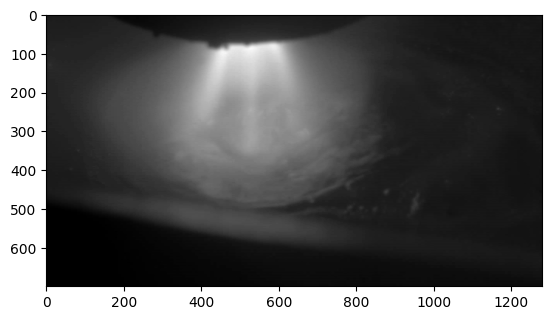

In [31]:
#var1='ss304/train/160705-114214-50mmLens w.s.75cm.m/image-0001.png' #op=5,high travel speed
#var2='ss304/test/160705-121434-50mmLens added slug/image-0001.png'  #op=2,contaimination
#var3='ss304/valid/160705-114925-50mmLens w.s.16cm.m/image-0150.png' #op=0,good weld 
#var4='ss304/test/160708-145105-50mmLens 350A w.s.Lev16 g.f.20L.m try joining 10mm Plate/image-0042.png' #op=3, lack of fusion
#var5='ss304/valid/161215-093333-run9/image-0278.png' #op=1, lack of fusion
#var6='ss304/test/160707-111307-50mmLens 200A w.s.11.5cm.m + no shielding gas/image-0219.png #op4,lack of sheilding glass

CNN_model=load_previous_model(CNN_model)
var_input=input('Enter path of the image to test: ')
print(f'Input image: {var_input}')
op_list=["good weld","burn through","contamination","lack of fusion","lack of shielding gas","high travel speed"]
test_image=convert_to_array(var_input,[],1)
prediction=CNN_model.predict(test_image.reshape(1,200,200,1))
print(prediction)
prediction=np.argmax(prediction)
print(f'output obtained: {prediction}')
print(f'Final output: {op_list[prediction]}')